# STAT 4710J Final Data Challenge

A taxi company is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an rider share app account. We consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days. **The data was collected at the end of June 30, 2014.**
We would like you to use this dataset to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help the company.
The data is in the attached file data_challenge.json. See below for a detailed
description of the dataset. 

**Data description**

city: city this user signed up in

phone: primary device for this user

signup_date: date of account registration; in the form ‘YYYYMMDD’

last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’

avg_dist: the average distance in miles per trip taken in the first 30 days after signup

avg_rating_by_driver: the rider’s average rating over all of their trips

avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips

surge_pct: the percent of trips taken with surge multiplier > 1

avg_surge: The average surge multiplier over all of this user’s trips

trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up

ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days;

FALSE otherwise

weekday_pct: the percent of the user’s trips occurring during a weekday



Please include any code you wrote for the analysis.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis.
2. Build a predictive model to help the company determine whether or not a user will be active
on the system. Discuss why you chose your approach, what
alternatives you considered, and any concerns you have. How valid is your model?
Include any key indicators of model performance.


**If you use Chatgpt in any of the sections, please state clearly how you reference Chatgpt, with a proper declaration, we might take you points off if we find duplicate codes produced from Chatgpt**

Grade break down: 60% on data analysis in the notebook (completeness, accuracy and interpretation) + 40% on test accuracy



In [1]:
#set up environment
import pandas as pd
import numpy as np
import json
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

#load data and visualize
with open('train.json') as f:
    data = json.load(f)
    
df = pd.DataFrame(data)
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,Winterfell,1,2014-01-27,3.5,1.67,2014-06-22,iPhone,33.3,True,16.7,2.10,4.8
1,King's Landing,1,2014-01-11,5.0,1.00,2014-06-08,iPhone,0.0,False,0.0,7.30,5.0
2,King's Landing,0,2014-01-23,3.0,1.00,2014-06-27,iPhone,0.0,True,100.0,4.00,5.0
3,King's Landing,0,2014-01-17,4.0,1.00,2014-05-31,Android,0.0,False,33.3,6.73,5.0
4,King's Landing,1,2014-01-28,5.0,1.16,2014-06-20,iPhone,26.9,True,50.0,2.48,4.8


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47500 entries, 0 to 47499
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    47500 non-null  object 
 1   trips_in_first_30_days  47500 non-null  int64  
 2   signup_date             47500 non-null  object 
 3   avg_rating_of_driver    39746 non-null  float64
 4   avg_surge               47500 non-null  float64
 5   last_trip_date          47500 non-null  object 
 6   phone                   47128 non-null  object 
 7   surge_pct               47500 non-null  float64
 8   ultimate_black_user     47500 non-null  bool   
 9   weekday_pct             47500 non-null  float64
 10  avg_dist                47500 non-null  float64
 11  avg_rating_by_driver    47311 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.4+ MB


In [3]:
df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,47500.000000,39746.000000,47500.000000,47500.000000,47500.000000,47500.000000,47311.000000
mean,2.275158,4.602186,1.074716,8.852829,60.966623,5.799024,4.778400
std,3.789220,0.617603,0.222291,19.993570,37.064133,5.677958,0.447863
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.890000,5.000000
75%,3.000000,5.000000,1.050000,8.500000,100.000000,6.950000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,129.890000,5.000000


### 1. EDA
a. First of all, all the users will need to be labled by active or inactive, and categorical variables must be encoded. The null values must be accounted for. While the reason for the missing ratings cannot be inferred, it seems reasonable that the user/driver simply declined to input a rating. In this case, we will fill with the **mean value** so as to not affect the current distribution, which is primarily high ratings.

In [4]:
#fill missing values in avg_rating_by_driver and avg_rating_of_driver
df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].mean(), inplace=True)
df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].mean(), inplace=True)

b. The target variable will be whether the user was active. Convert the signup date and last trip date to datetime objects. If the last trip is in June, then encode each user active as True, else False.

In [5]:
#set as datatime objects
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

In [6]:
#encode target variable 'active' as true or false for last trip in june
# you can add more lines before assigning the 'active' column
df['active'] = df['last_trip_date'].apply(lambda x: True if x.month == 6 else False)

#### What is the ratio of Active Users to Inactive Users?
Compute the percentage of active users among all users, and make a plot to visualize it.

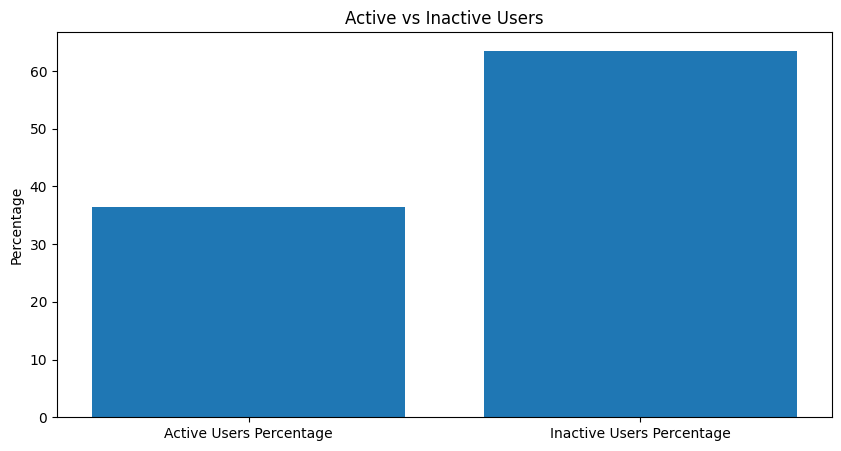

In [7]:
#Calculate ratio of active to all users
active_users = df['active'].sum()
all_users = len(df)
inactive_users = all_users - active_users
active_ratio = active_users/all_users * 100
inactive_ratio = inactive_users/all_users * 100
#Visualization
plt.figure(figsize=(10,5))
plt.bar(['Active Users Percentage', 'Inactive Users Percentage'], [active_ratio, inactive_ratio])
plt.ylabel('Percentage')
plt.title('Active vs Inactive Users')
plt.show()

Unsurprisingly the classes are imbalanced, but not tremendously. This should not present too much of a problem while modeling.

c. In the cell below, show a visualization that you used to select features for your model.

Include:

1. At least one plot showing something meaningful about the data that helped you during feature selection, model selection, or both.

2. Two or three sentences describing what you plotted and its implications with respect to your features.



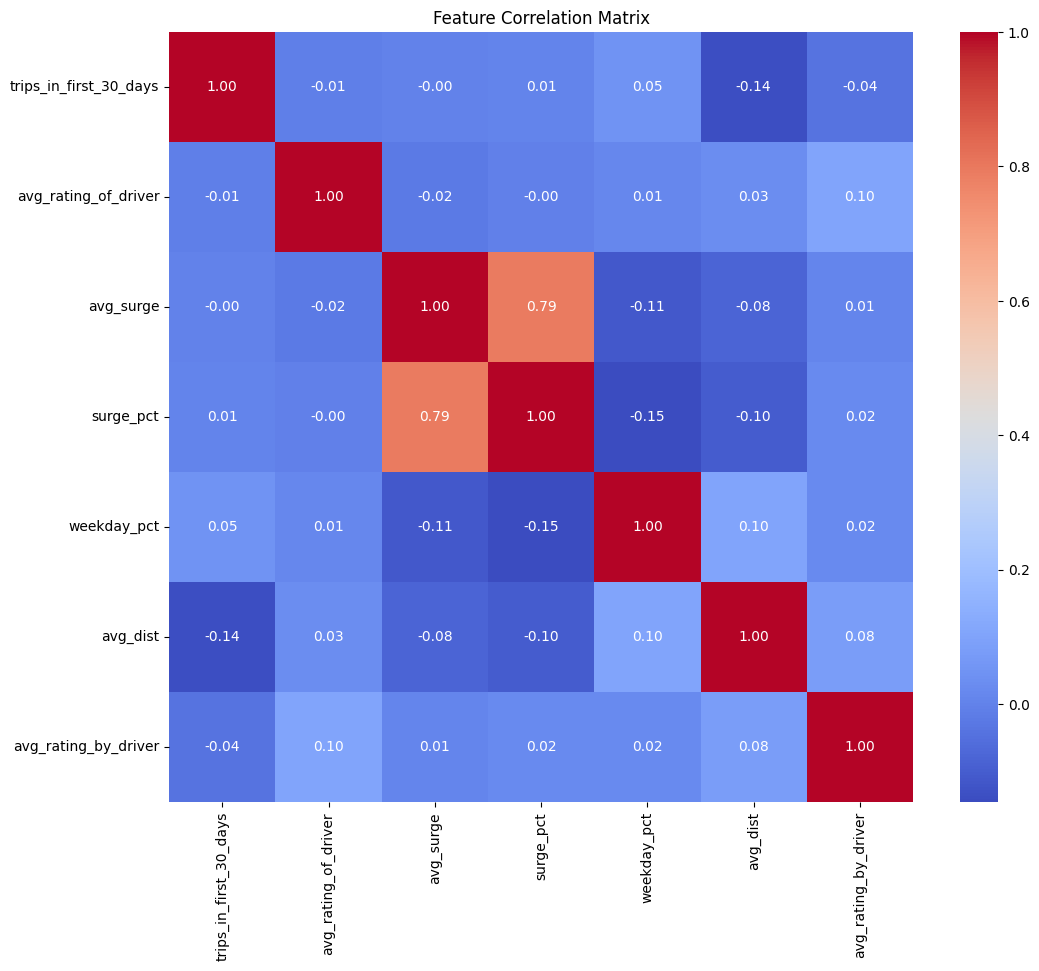

In [8]:
# by ChatGPT
numeric_df = df.select_dtypes(include=[np.number])

corr_matrix = numeric_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.show()


The correlation matrix helps us identify which features are strongly correlated with each other and which ones might have redundant information. For example, avg_surge and surge_pct show a high correlation, suggesting they might carry similar information. Additionally, features like trips_in_first_30_days and weekday_pct show relatively low correlations with other features, indicating they may provide independent information, making them good candidates for inclusion in the model.

## 2. Modeling

Now, please perform feature engineering to build a model that can predict whether the users are active. (To get full credit, you need to make some visualization and try out several different models using cross validation)

In [9]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active
0,Winterfell,1,2014-01-27,3.5,1.67,2014-06-22,iPhone,33.3,True,16.7,2.10,4.8,True
1,King's Landing,1,2014-01-11,5.0,1.00,2014-06-08,iPhone,0.0,False,0.0,7.30,5.0,True
2,King's Landing,0,2014-01-23,3.0,1.00,2014-06-27,iPhone,0.0,True,100.0,4.00,5.0,True
3,King's Landing,0,2014-01-17,4.0,1.00,2014-05-31,Android,0.0,False,33.3,6.73,5.0,False
4,King's Landing,1,2014-01-28,5.0,1.16,2014-06-20,iPhone,26.9,True,50.0,2.48,4.8,True


In [10]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

def preprocess_data(df):
    df['phone'].fillna('Other', inplace=True)
    df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].mean(), inplace=True)
    df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].mean(), inplace=True)
    # Encode categorical variables
    le = LabelEncoder()
    df['city'] = le.fit_transform(df['city'])
    df['phone'] = le.fit_transform(df['phone'])

    df.drop(['signup_date', 'last_trip_date'], axis=1, inplace=True)
    # prepare data for training
    y = df['active']
    X = df.drop('active', axis=1)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    return X, y

X, y = preprocess_data(df)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


Logistic Regression Classification Report:
              precision    recall  f1-score   support

       False       0.72      0.87      0.78      6064
        True       0.63      0.39      0.48      3436

    accuracy                           0.70      9500
   macro avg       0.67      0.63      0.63      9500
weighted avg       0.68      0.70      0.67      9500

[[5271  793]
 [2097 1339]]
Random Forest Classification Report:
              precision    recall  f1-score   support

       False       0.80      0.81      0.80      6064
        True       0.65      0.65      0.65      3436

    accuracy                           0.75      9500
   macro avg       0.73      0.73      0.73      9500
weighted avg       0.75      0.75      0.75      9500

[[4888 1176]
 [1215 2221]]
Gradient Boosting Classification Report:
              precision    recall  f1-score   support

       False       0.81      0.85      0.83      6064
        True       0.71      0.65      0.68      3436

    acc

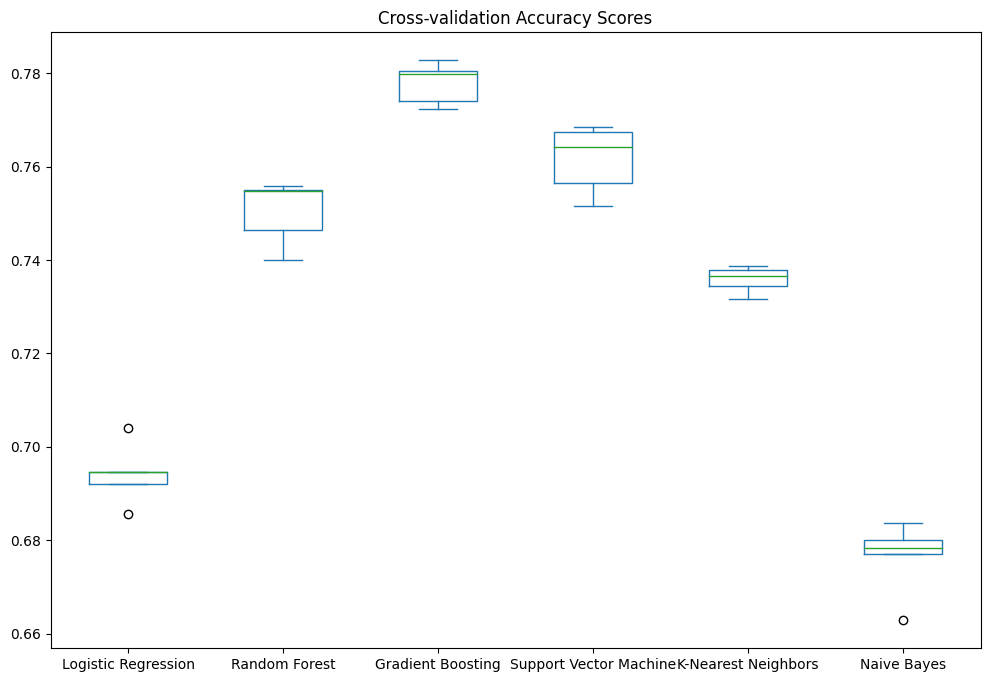

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix


# Train and evaluate models using cross-validation
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Support Vector Machine': SVC(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
}

results = {}
for model_name, model in models.items():
    # cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    results[model_name] = cv_scores
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    print(f'{model_name} Classification Report:')
    print(classification_report(y_val, y_pred))
    print(confusion_matrix(y_val, y_pred))

# Find and store the best model based on cross-validation accuracy scores
best_model_name = max(results, key=lambda k: results[k].mean())
best_model = models[best_model_name]

# Visualize cross-validation results
cv_df = pd.DataFrame(results)
cv_df.plot(kind='box', figsize=(12, 8))
plt.title('Cross-validation Accuracy Scores')
plt.show()


## 3. Model Evaluation

The bottom line here is: Was the model useful? You need to check both **numerical metrics and visual metrics**. **Please explain different performance metrics and your results.**

In [12]:
best_model_name

'Gradient Boosting'

We decide to choose the best 3 models in the above models to analyze.
- Random Forest
- Support Vector Machine
- Gradient Boosting

              precision    recall  f1-score   support

       False       0.81      0.85      0.83      6064
        True       0.71      0.65      0.68      3436

    accuracy                           0.78      9500
   macro avg       0.76      0.75      0.76      9500
weighted avg       0.78      0.78      0.78      9500

[[5175  889]
 [1213 2223]]


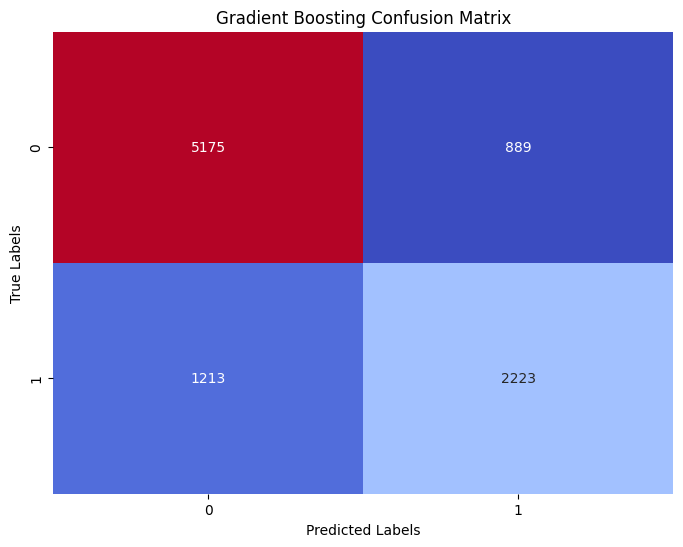

In [13]:
from sklearn.metrics import classification_report, confusion_matrix
# Gradient Boosting Model
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_val)

print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))
# heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, cmap='coolwarm', fmt='d', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Gradient Boosting Confusion Matrix')
plt.show()


              precision    recall  f1-score   support

       False       0.78      0.87      0.83      6064
        True       0.72      0.57      0.64      3436

    accuracy                           0.77      9500
   macro avg       0.75      0.72      0.73      9500
weighted avg       0.76      0.77      0.76      9500

[[5303  761]
 [1471 1965]]


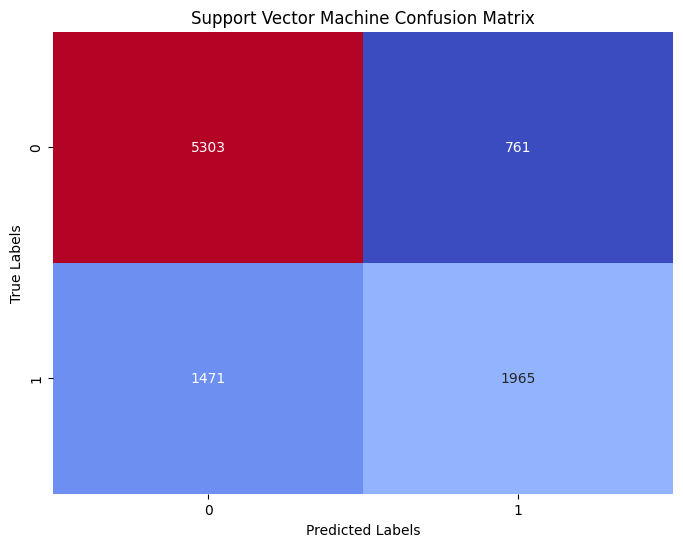

In [14]:
# Support Vector Machine Model
model = SVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))
# heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, cmap='coolwarm', fmt='d', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Support Vector Machine Confusion Matrix')
plt.show()

              precision    recall  f1-score   support

       False       0.80      0.80      0.80      6064
        True       0.65      0.65      0.65      3436

    accuracy                           0.75      9500
   macro avg       0.72      0.72      0.72      9500
weighted avg       0.75      0.75      0.75      9500

[[4867 1197]
 [1218 2218]]


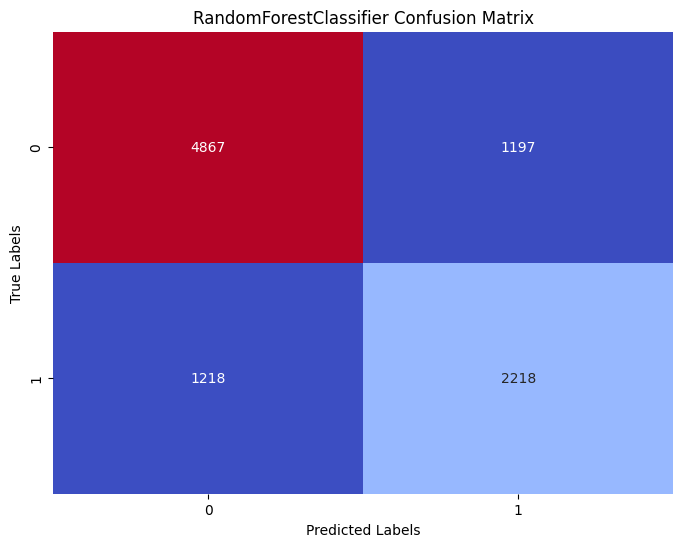

In [15]:
# Random Forest Model
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))
# heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, cmap='coolwarm', fmt='d', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('RandomForestClassifier Confusion Matrix')
plt.show()

### Analysis

1. **RandomForestClassifier**:
   - Has a balanced performance with an overall accuracy of 74%.
   - Precision, recall, and F1-score for both classes are relatively close, indicating a balanced model without a significant bias towards either class.

2. **Support Vector Machine (SVM)**:
   - Has the highest overall accuracy of 77%.
   - Higher recall for class 0 (Inactive), but lower recall for class 1 (Active) compared to the RandomForestClassifier.
   - This model is more conservative in predicting class 1, leading to a higher number of false negatives (1471).

3. **Gradient Boosting Classifier**:
   - Has a balanced performance similar to RandomForestClassifier, with an overall accuracy of 78%.
   - Slightly higher precision and recall for class 1 compared to the RandomForestClassifier, making it slightly better at predicting active users.
   - Lowest number of false positives (889) among the three models, indicating better precision for inactive users.

### Conclusion
- **Support Vector Machine (SVM)** has the highest overall accuracy but shows a tendency to predict fewer active users, leading to a higher number of false negatives.
- **Gradient Boosting Classifier** seems to provide the best balance between precision and recall for both classes, making it the most reliable model for predicting active users.
- **RandomForestClassifier** is also balanced but performs slightly worse than the Gradient Boosting Classifier in terms of precision and recall for active users.

Overall, the **Gradient Boosting Classifier** would be the recommended model due to its balanced performance and slightly better precision and recall for predicting active users.

## 4. Final Submission




The following code will write your predictions on the test dataset to a CSV file. **You will need to submit this file to get credit for this question.**

Save your predictions in a 1-dimensional array called `test_predictions` (contains 0 and 1s). 

Remember that if you've performed transformations or featurization on the training data, you must also perform the same transformations on the test data in order to make predictions. 


### Submission on Canvas

Please push submit your work (ipynb, submission.csv) to Canvas



In [16]:
test = pd.read_csv('test.csv')
test['phone'].fillna('Other', inplace=True)
test['avg_rating_by_driver'].fillna(test['avg_rating_by_driver'].mean(), inplace=True)
test['avg_rating_of_driver'].fillna(test['avg_rating_of_driver'].mean(), inplace=True)
# Encode categorical variables
le = LabelEncoder()
test['city'] = le.fit_transform(test['city'])
test['phone'] = le.fit_transform(test['phone'])
scaler = StandardScaler()
test = scaler.fit_transform(test)
test_predictions = best_model.predict(test)
# transform True and False to 1 and 0
test_predictions = test_predictions.astype(int)

In [17]:
submission_df = pd.DataFrame({ 
    "active": test_predictions
}, columns=['active'])
submission_df.to_csv("submission.csv", index=False)

print('Created a CSV file: submission.csv')
print('You may now upload this CSV file to Canvas for grading.')

Created a CSV file: submission.csv
You may now upload this CSV file to Canvas for grading.


Acknowledgement: ChatGPT
- Ask ChatGPT to help me do analysis on several different models(section 3).